In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import generate_pinwheel, generate_spiral, generate_checkerboard, generate_gaussian_mixtures

device = "cpu" 

In [2]:
rng = np.random.default_rng(seed=54301)

X_pinwheel = generate_pinwheel(num=2000, rng=rng)
pinwheel_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_pinwheel)),
    batch_size=128,
    shuffle=True
)

X_spiral = generate_spiral(num=2000, rng=rng)
spiral_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_spiral)),
    batch_size=128,
    shuffle=True
)


X_checkerboard = generate_checkerboard(num=2000, rng=rng)
checkerboard_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_checkerboard)),
    batch_size=128,
    shuffle=True
)


X_gmm = generate_gaussian_mixtures(num=2000, rng=rng)
gmm_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_gmm)),
    batch_size=128,
    shuffle=True
)

In [3]:
from vae import train_vae
from gan import train_gan


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [00:54<00:00, 14.71it/s]


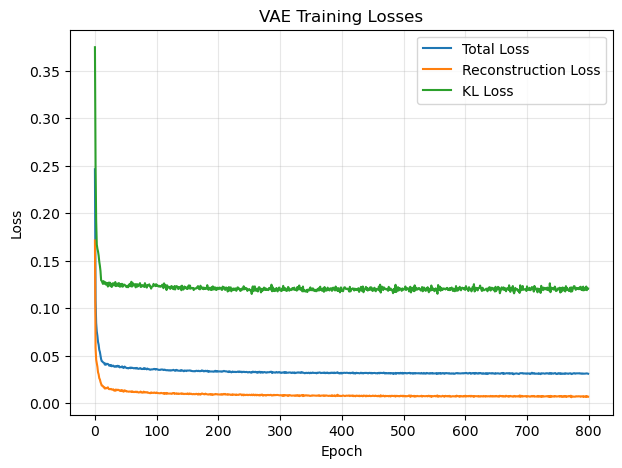

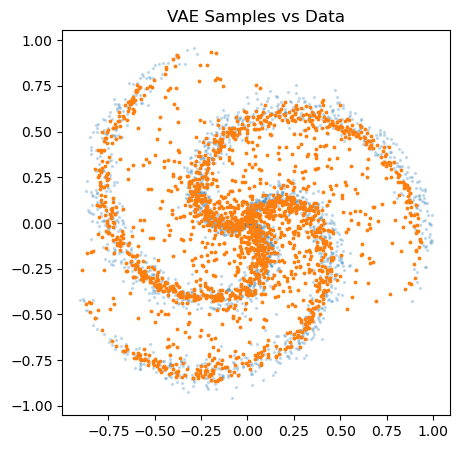

In [4]:
train_vae(pinwheel_loader, X_pinwheel, epochs=800, device="cpu")


Training GAN...


Epochs: 100%|███████████████████████████████| 1000/1000 [00:42<00:00, 23.35it/s]


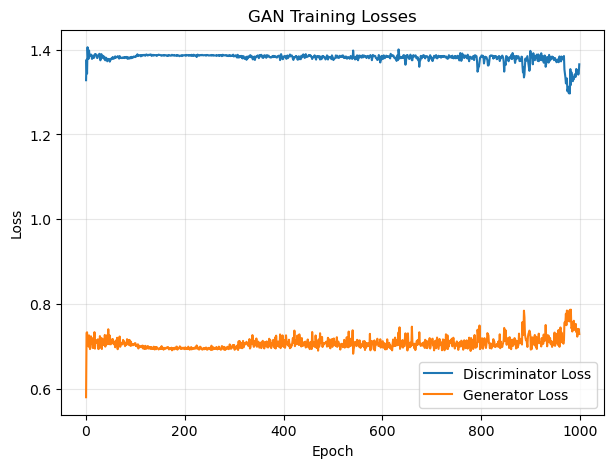

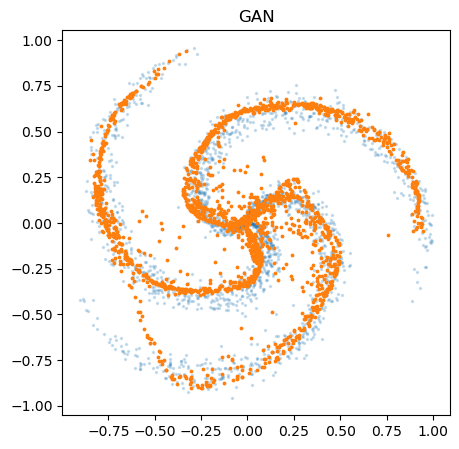

In [5]:
train_gan(pinwheel_loader, X_pinwheel, epochs=1000, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:44<00:00, 14.39it/s]


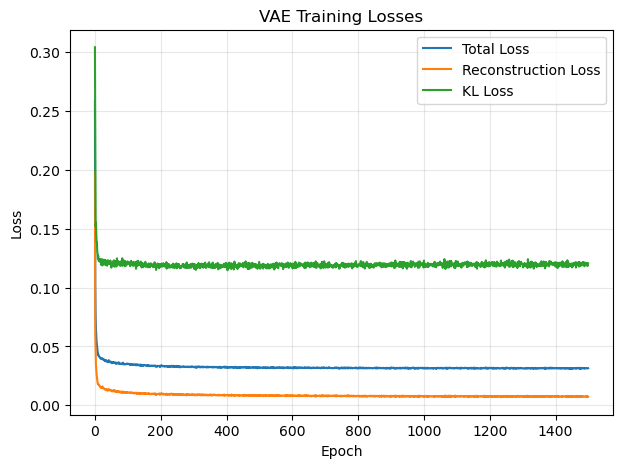

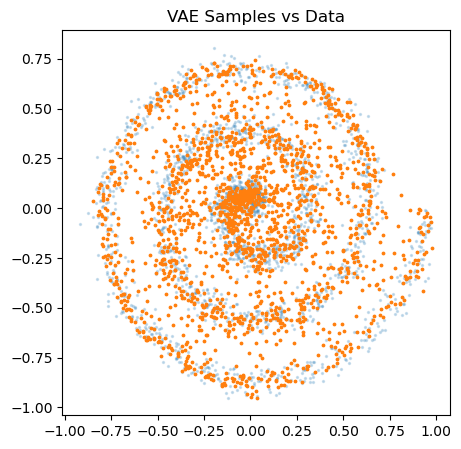

In [6]:
train_vae(spiral_loader, X_spiral, epochs=1500, device="cpu")


Training GAN...


Epochs: 100%|███████████████████████████████| 1200/1200 [00:53<00:00, 22.48it/s]


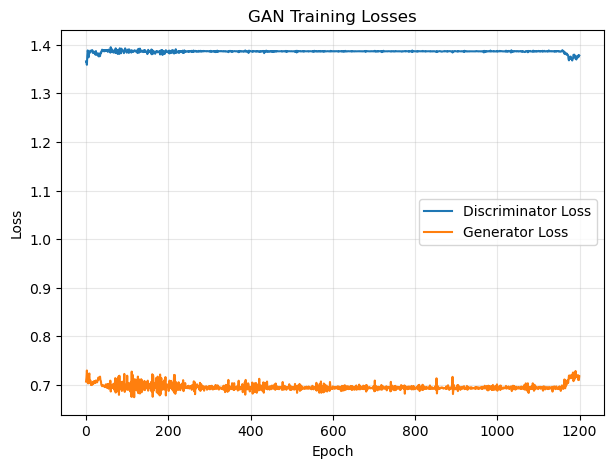

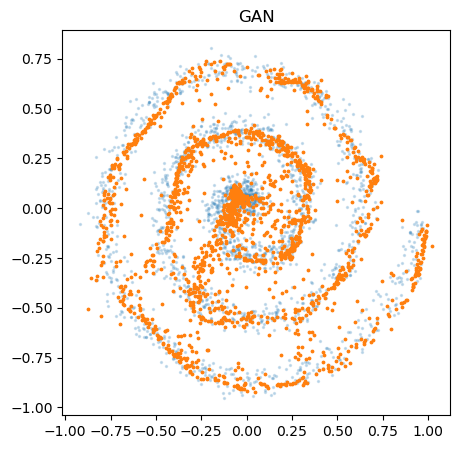

In [7]:
train_gan(spiral_loader, X_spiral, epochs=1200, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1000/1000 [01:09<00:00, 14.29it/s]


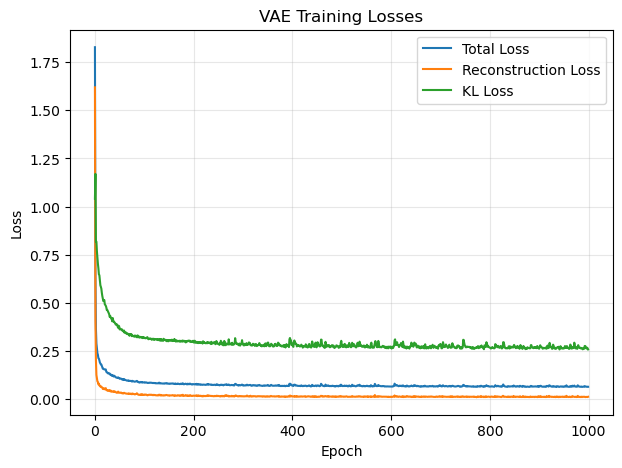

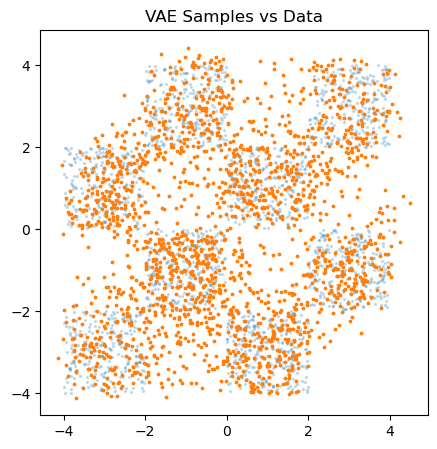

In [8]:
train_vae(checkerboard_loader, X_checkerboard, epochs=1000, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 650/650 [00:28<00:00, 22.67it/s]


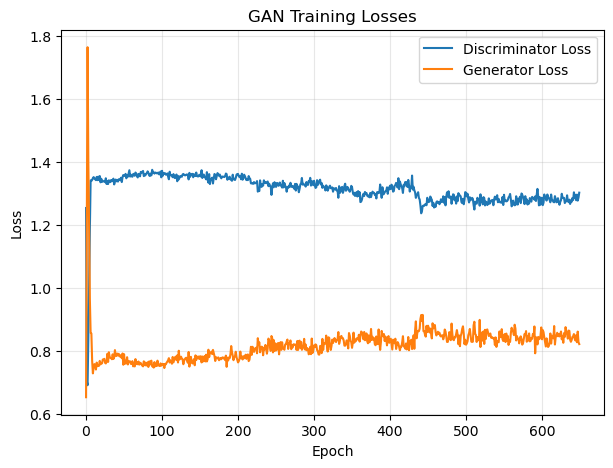

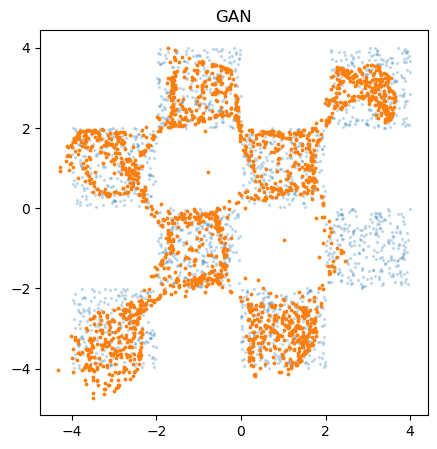

In [9]:
train_gan(checkerboard_loader, X_checkerboard, epochs=650, device="cpu")


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [00:52<00:00, 15.32it/s]


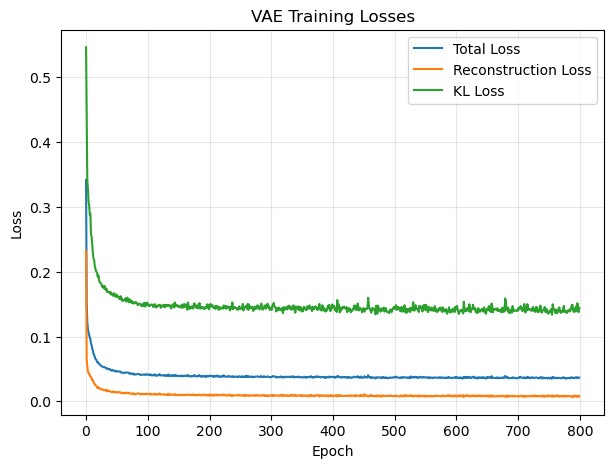

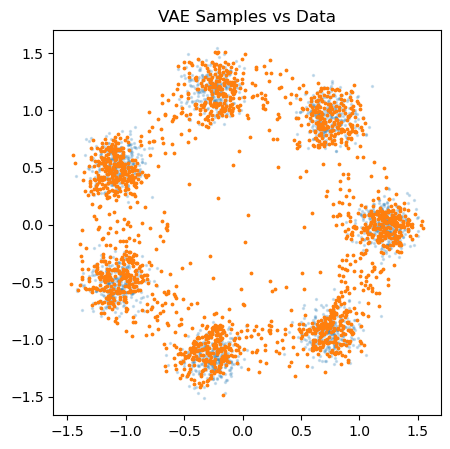

In [10]:
train_vae(gmm_loader, X_gmm, epochs=800, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 400/400 [00:17<00:00, 22.75it/s]


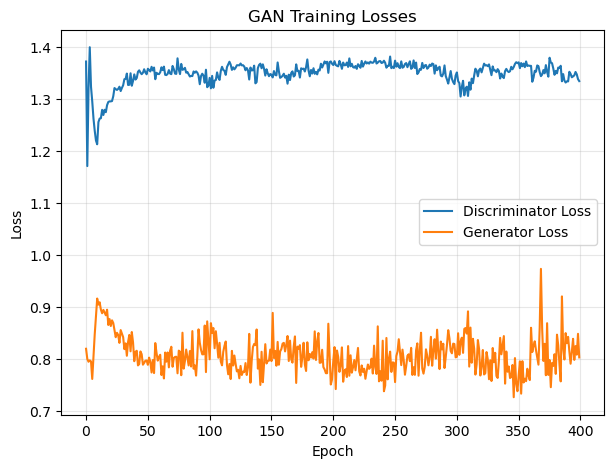

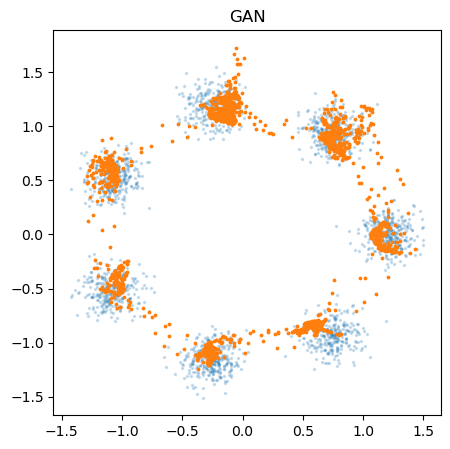

In [11]:
train_gan(gmm_loader, X_gmm, epochs=400, device="cpu")